---
# Исследовательский анализ данных (EDA)

> **🎯 Цель этого ноутбука:** Изучить датасет с вопросами ЧГК, чтобы понять его структуру, найти скрытые закономерности и подготовить почву для обучения кастомной NER-модели.

**Ключевые вопросы, на которые мы ответим:**
1.  Какова общая структура и качество данных?
2.  Есть ли временные тренды в создании вопросов? Кто самые активные авторы и редакторы?
3.  Каковы характеристики текстов вопросов и ответов (длина, популярные слова)?
4.  Какие именованные сущности (люди, места, даты, произведения) чаще всего встречаются в вопросах?
---

## Часть 0: Загрузка и подготовка данных

На этом этапе мы загрузим все необходимые библиотеки, прочитаем наш датасет и приведем его в удобный для анализа вид.

### 0.1. Импорт библиотек

In [ ]:
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from tqdm import tqdm
from collections import Counter

[nltk_data] Downloading package stopwords to /Users/boris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 0.2. Загрузка данных

In [3]:
df = pd.read_parquet('../data/got_q_db.parquet')

### 0.3. Первичный осмотр и преобразование типов

In [4]:
df.head()

,id,number,text,razdatkaText,razdatkaPic,answer,zachet,comment,source,author,title,date
0,420110,1,Хотя апачи кидали выпотрошенных койотов в коло...,,,тактика выжженной земли.,стратегия выжженной земли.,в исходном смысле эти слова относились к уничт...,"П. Коззенс, «И будет рыдать земля» (https://bi...",Андрей Скиренко,IV Гран-при текстильной столицы,2023-11-05 16:00:00
1,420111,2,В одном шоу актёры Дэвид Теннант и Майкл Шин с...,,,среднее имя.,"второе имя, имя Кристофер.","Майкл Шин настаивал, что именно он должен идти...","т/с «Постановка», 1 сезон, 1 серия.",Дмитрий Рыжков,IV Гран-при текстильной столицы,2023-11-05 16:00:00
2,420112,3,Карфагенский мореплаватель Ганно́н описывал вс...,,,горилла.,,плававший в район Гвинейского залива в V веке ...,https://en.wikipedia.org/wiki/Gorilla\nhttps:/...,Андрей Скиренко,IV Гран-при текстильной столицы,2023-11-05 16:00:00
3,420113,4,Спустя четверть века группа записала в поддерж...,,,«Status Quo» [ста́тус кво].,,один из наиболее крупных хитов группы – изнача...,https://en.wikipedia.org/wiki/In_the_Army_Now_...,Андрей Скиренко,IV Гран-при текстильной столицы,2023-11-05 16:00:00
4,420114,5,"Герои сериала «Рим» – простые легионеры, котор...",Vorenus and Pullo jump their way through ancie...,,Forrest Gump [фо́ррэст гамп].,"с небольшими отклонениями, в любой капитализации",действие сериала проходит на фоне гражданской ...,«Using “Forrest Gump” as a Verb» (https://bit....,Дмитрий Пономарёв,IV Гран-при текстильной столицы,2023-11-05 16:00:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311068 entries, 0 to 311067
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            311068 non-null  int64 
 1   number        311068 non-null  int64 
 2   text          311068 non-null  object
 3   razdatkaText  311068 non-null  object
 4   razdatkaPic   311068 non-null  object
 5   answer        311068 non-null  object
 6   zachet        311068 non-null  object
 7   comment       311068 non-null  object
 8   source        311068 non-null  object
 9   author        294430 non-null  object
 10  title         311068 non-null  object
 11  date          311068 non-null  object
dtypes: int64(2), object(10)
memory usage: 28.5+ MB


In [6]:
df['date'] = pd.to_datetime(df['date'])

---
## Часть 1: Анализ метаданных

Изучим всё, что окружает текст вопроса: время, авторов, турниры.

### 1.1. Временной анализ

Как менялось количество вопросов и турниров с течением времени?

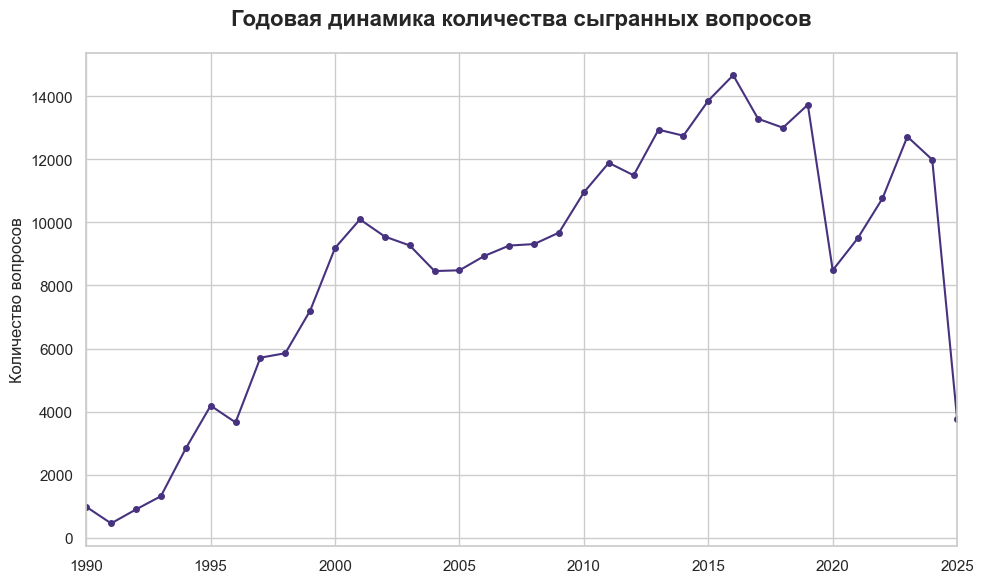

In [9]:
sns.set_theme(style="whitegrid", palette="viridis")
plt.figure(figsize=(10, 6))

yearly_counts = df.set_index('date')['id'].resample('YE').count()
ax = yearly_counts.plot(
    marker='.',          
    linestyle='-',             
    markersize=8         
)

plt.title('Годовая динамика количества сыгранных вопросов', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество вопросов', fontsize=12)
plt.xticks(rotation=0) 

ax.set_xlabel(None)

plt.tight_layout()
plt.show()

1.  **Долгосрочный рост (1990-2019):** На протяжении почти 30 лет наблюдался устойчивый рост количества сыгранных вопросов: от менее чем 1000 в начале 90-х до пиковых значений свыше 14 000 в 2016-2019 годах. Это говорит о значительном росте популярности и масштаба интеллектуальных игр.

2.  **Периоды активного роста:** Особенно выделяются два периода:
    *   **1992-2001 гг.:** "Взрывной" рост, когда активность увеличилась более чем в 10 раз.
    *   **2005-2016 гг.:** Второй, более плавный, но стабильный подъем, который привел к историческим максимумам.

3.  **"Ковидный" провал (2020):** В 2020 году произошло резкое падение активности (почти на 40% от пиковых значений). Это почти наверняка связано с пандемией COVID-19 и отменой массовых очных мероприятий.

4.  **Пост-пандемическое восстановление (2021-2024):** После провала 2020 года начался период восстановления. В 2023 году количество вопросов почти вернулось к допандемийным значениям. Дальнейшая динамика показывает, что активность восстанавливается, хотя и с некоторыми колебаниями.

### 1.2. Анализ авторов и редакторов

Кто самые продуктивные создатели контента в мире ЧГК?

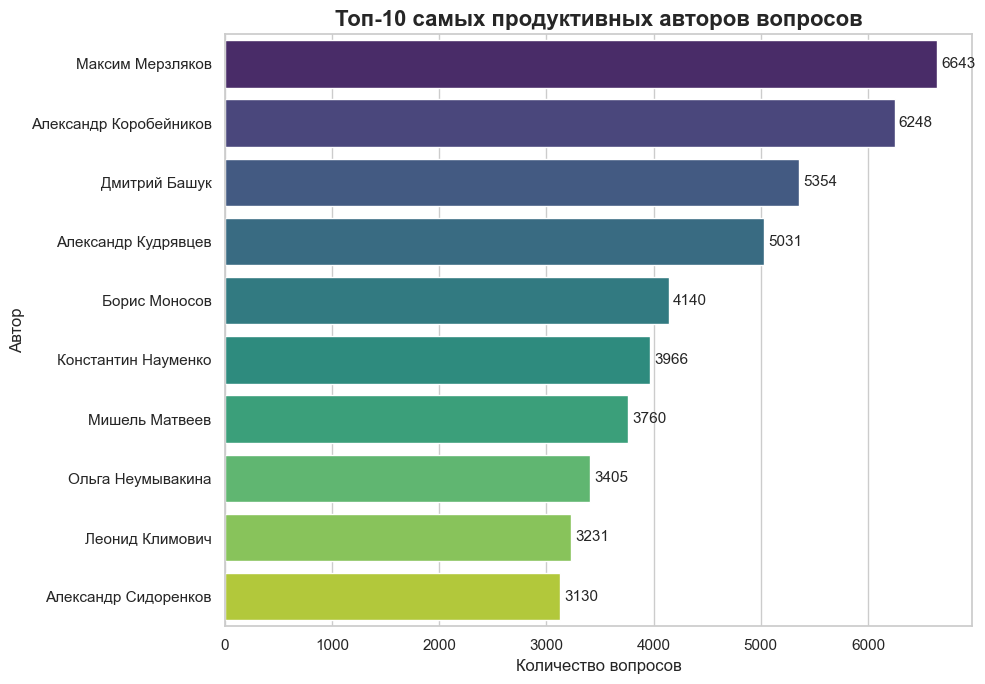

In [ ]:
top_10_authors = df['author'].value_counts().head(10)
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 7))
ax = sns.barplot(x=top_10_authors.values, y=top_10_authors.index, palette="viridis", hue=top_10_authors.index, legend=False)

ax.set_title('Топ-10 самых продуктивных авторов вопросов', fontsize=16, fontweight='bold')
ax.set_xlabel('Количество вопросов', fontsize=12)
ax.set_ylabel('Автор', fontsize=12)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=11)

plt.tight_layout()
plt.show()

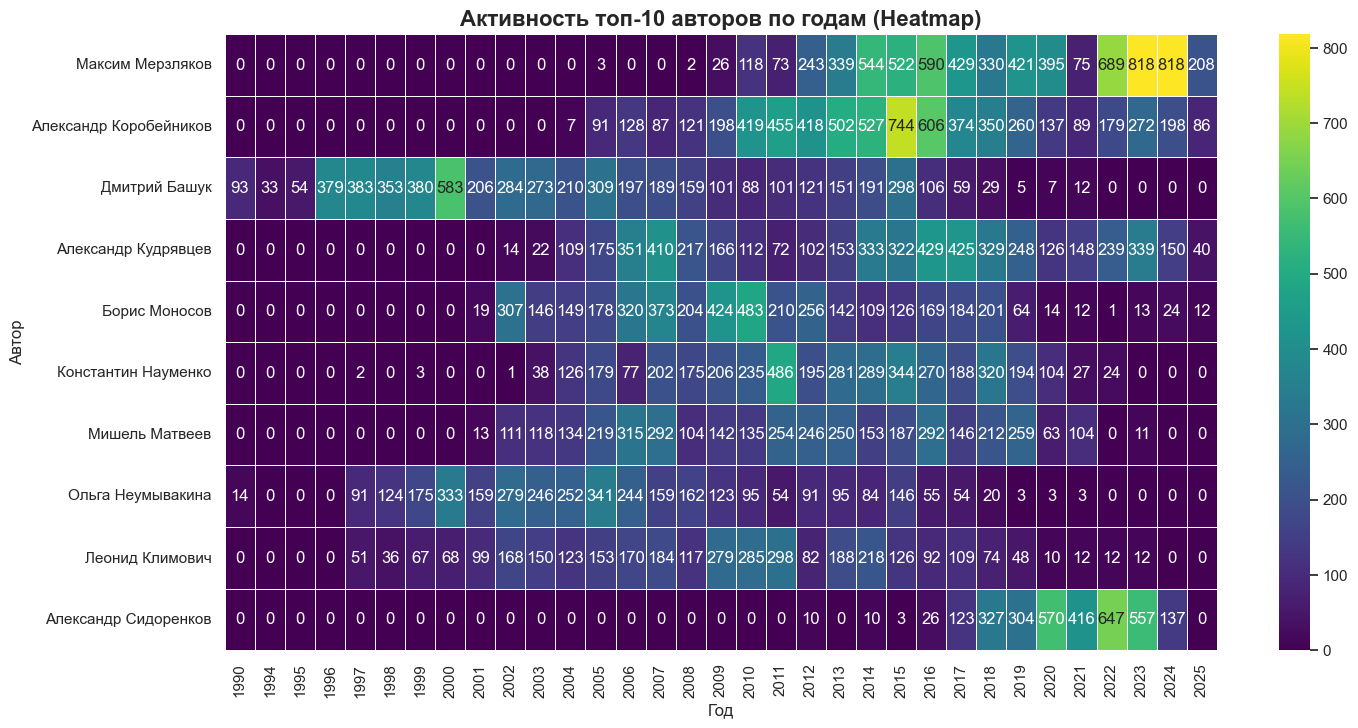

In [ ]:
top_10_author_names = top_10_authors.index.tolist()
df_top10 = df[df['author'].isin(top_10_author_names)].copy()

df_top10['date'] = pd.to_datetime(df_top10['date'], errors='coerce')
df_top10.dropna(subset=['date'], inplace=True)


df_top10['year'] = df_top10['date'].dt.year

author_yearly_counts = df_top10.groupby(['author', 'year']).size().reset_index(name='question_count')

author_yearly_counts['author'] = pd.Categorical(author_yearly_counts['author'], categories=top_10_author_names, ordered=True)
author_yearly_counts = author_yearly_counts.sort_values('author')

heatmap_data = author_yearly_counts.pivot_table(
    index='author',
    columns='year',
    values='question_count',
    fill_value=0,
    observed=False
)

plt.figure(figsize=(16, 8))
heatmap_data = heatmap_data.astype(int)

ax = sns.heatmap(
    heatmap_data,
    annot=True,      
    fmt='d',         
    cmap='viridis',  
    linewidths=.5    
)

ax.set_title('Активность топ-10 авторов по годам (Heatmap)', fontsize=16, fontweight='bold')
ax.set_xlabel('Год', fontsize=12)
ax.set_ylabel('Автор', fontsize=12)

plt.show()

1.  **Смена поколений авторов:** На графике четко прослеживается "эстафета" продуктивности. Авторы, доминировавшие в 1990-х и начале 2000-х (например, Дмитрий Башук), со временем снизили активность, уступив место новому поколению авторов, чей пик пришелся на 2010-е и 2020-е годы (Максим Мерзляков, Александр Сидоренков).

2.  **Рост пиковой продуктивности:** Максимальное количество вопросов от одного автора в год со временем росло. Если в 2001 году пик Дмитрия Башука составлял 583 вопроса, то в 2015-м Александр Коробейников написал 744, а в 2022-2024 годах Максим Мерзляков показывает феноменальные результаты (более 800 вопросов в год). Это может говорить как о росте числа турниров, так и о появлении "супер-авторов".

3.  **Ярко выраженные "карьерные дуги":** У большинства авторов есть четкий период взлета, пика (длительностью 3-5 лет) и последующего спада активности. Редко кто из авторов держит максимальную продуктивность на протяжении десятилетия.

4.  **Современные лидеры:** В последние годы (с ~2018) доминируют два автора: **Максим Мерзляков** и **Александр Сидоренков**. Их активность резко возросла и достигла значений, превосходящих почти всех остальных авторов в истории.

5.  **Специализация по времени:** Большинство авторов из топ-10 имеют свой "золотой век". Например, активность Ольги Неумывакиной была максимальной в конце 2000-х, а Бориса Моносова и Константина Науменко — в середине 2000-х и начале 2010-х.

---

## Часть 2: Глубокий анализ текстовых данных
### 2.1. Анализ длин текстов

Насколько длинные или короткие тексты нам предстоит обрабатывать? Это важно для настройки NLP-моделей.

In [16]:
df.fillna('', inplace=True)
df['question_len_words'] = df['text'].apply(lambda x: len(x.split()))
df['answer_len_words'] = df['answer'].apply(lambda x: len(x.split()))
df['comments_len_words'] = df['comment'].apply(lambda x: len(x.split()))

df[['question_len_words', 'answer_len_words', 'comments_len_words']].describe()

,question_len_words,answer_len_words,comments_len_words
count,311068.000000,311068.000000,311068.000000
mean,33.350959,2.485521,19.593536
std,14.636517,3.048424,19.115408
min,0.000000,0.000000,0.000000
25%,23.000000,1.000000,4.000000
50%,31.000000,2.000000,16.000000
75%,40.000000,3.000000,30.000000
max,200.000000,183.000000,162.000000


In [23]:
q_cutoff = df['question_len_words'].quantile(0.99)
a_cutoff = df['answer_len_words'].quantile(0.99)
c_cutoff = df['comments_len_words'].quantile(0.99)

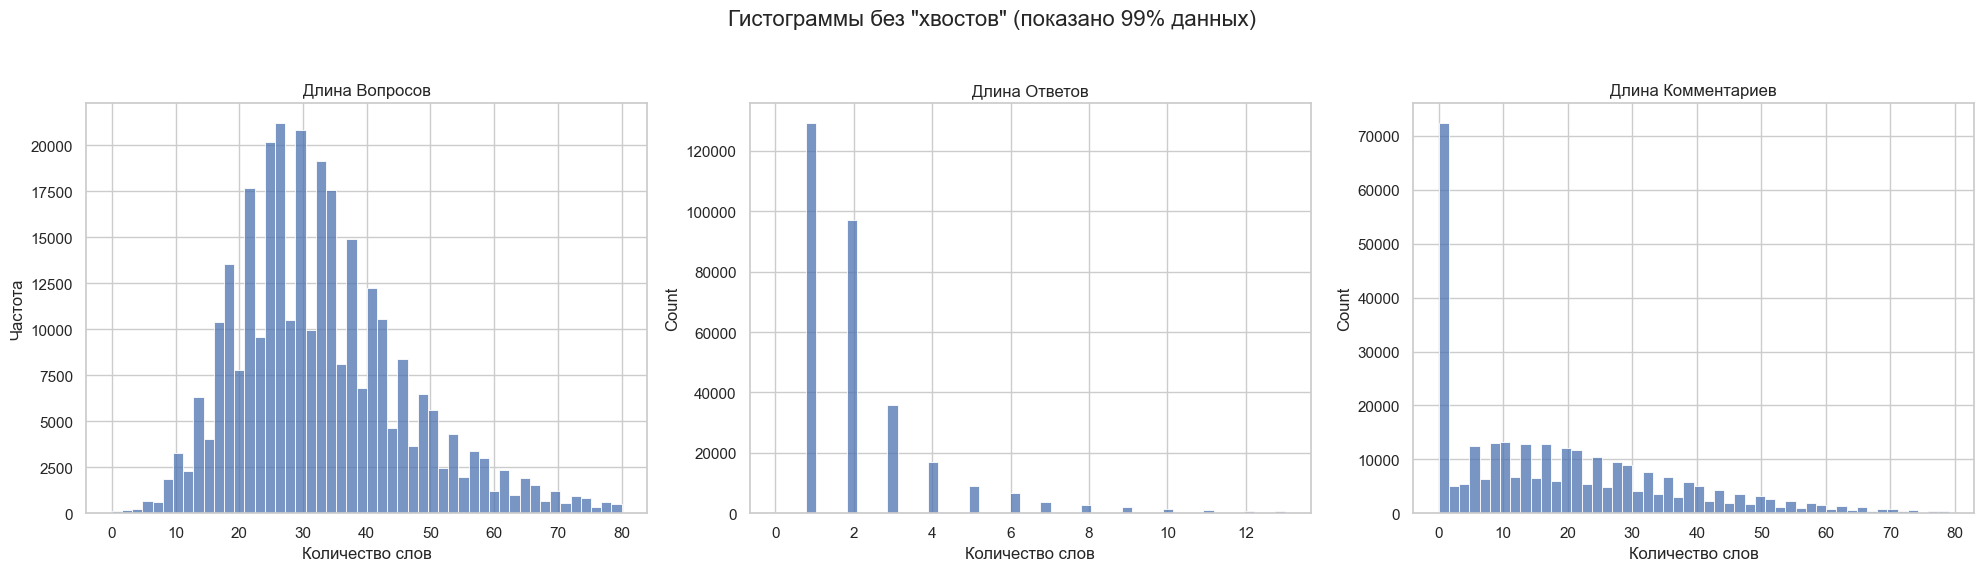

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Гистограммы без "хвостов" (показано 99% данных)', fontsize=16)

sns.histplot(df[df['question_len_words'] < q_cutoff]['question_len_words'], bins=50, ax=axes[0])
axes[0].set_title('Длина Вопросов')
axes[0].set_xlabel('Количество слов')
axes[0].set_ylabel('Частота')

sns.histplot(df[df['answer_len_words'] < a_cutoff]['answer_len_words'], bins=50, ax=axes[1])
axes[1].set_title('Длина Ответов')
axes[1].set_xlabel('Количество слов')

sns.histplot(df[df['comments_len_words'] < c_cutoff]['comments_len_words'], bins=50, ax=axes[2])
axes[2].set_title('Длина Комментариев')
axes[2].set_xlabel('Количество слов')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 2.2. Предобработка текста (очистка и лемматизация)

Подготовим текстовые данные для частотного анализа: приведем к нижнему регистру, уберем пунктуацию, стоп-слова и приведем слова к начальной форме (лемматизация).

In [ ]:
nlp = spacy.load("ru_core_news_sm", disable=["parser", "ner"])

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', '', text)

    doc = nlp(text)
    
    lemmas = [
        token.lemma_ for token in doc 
        if not token.is_stop and not token.is_punct and token.text.strip()
    ]       
    return lemmas

tqdm.pandas(desc="Processing questions")
df['lemmatized_q'] = df['text'].progress_apply(preprocess_text)

tqdm.pandas(desc="Processing answers")
df['lemmatized_a'] = df['answer'].progress_apply(preprocess_text)

tqdm.pandas(desc="Processing comments")
df['lemmatized_c'] = df['comment'].progress_apply(preprocess_text)


Processing comments: 100%|██████████| 311068/311068 [20:49<00:00, 248.90it/s] 


### 2.3. Частотный анализ (Униграммы)

Какие слова являются самыми популярными в вопросах и ответах?

In [ ]:
def get_most_common_words(corpus: pd.Series, n: int = 20) -> list[tuple[str, int]]:

    all_words = [word for text_list in corpus for word in text_list]
    word_counts = Counter(all_words)

    return word_counts.most_common(n)

def plot_most_common_words(word_counts: list[tuple[str, int]], title: str):
    words_df = pd.DataFrame(word_counts, columns=['word', 'count'])
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='count', y='word', data=words_df, palette='viridis', hue='word', legend=False)
    plt.title(title, fontsize=16)
    plt.xlabel('Частота', fontsize=12)
    plt.ylabel('Слово', fontsize=12)
    plt.tight_layout()
    plt.show()

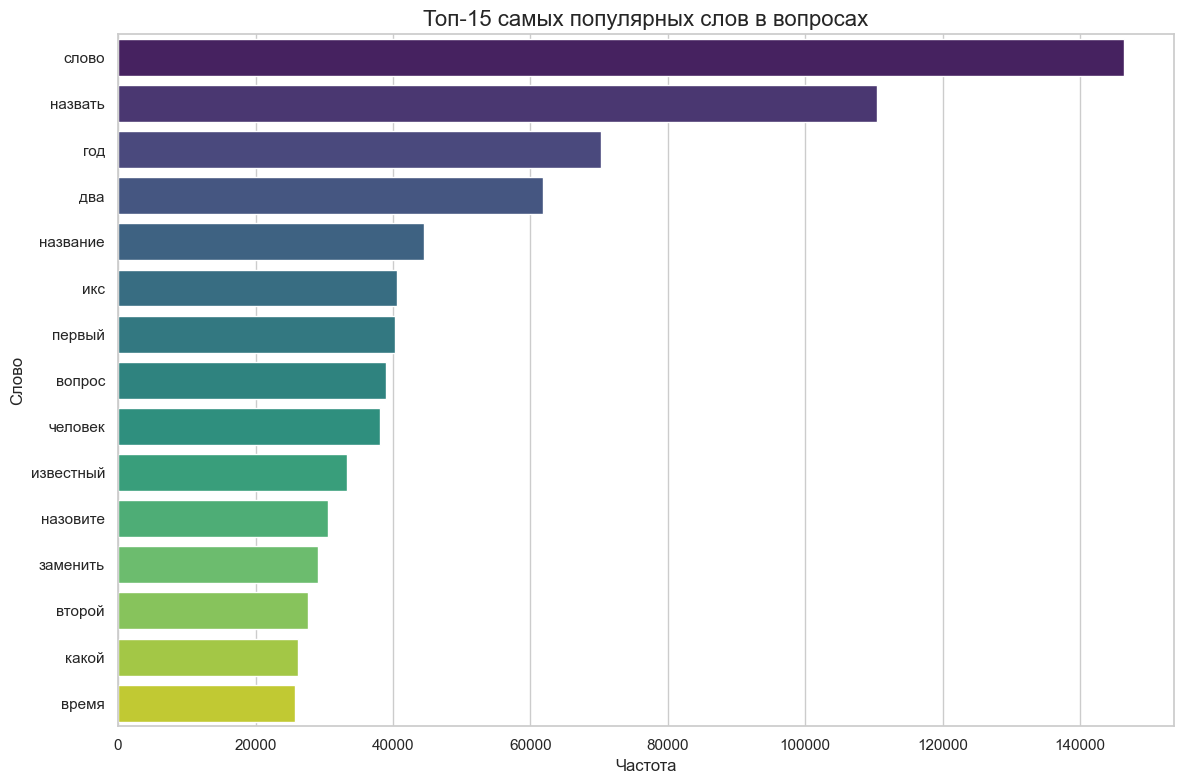

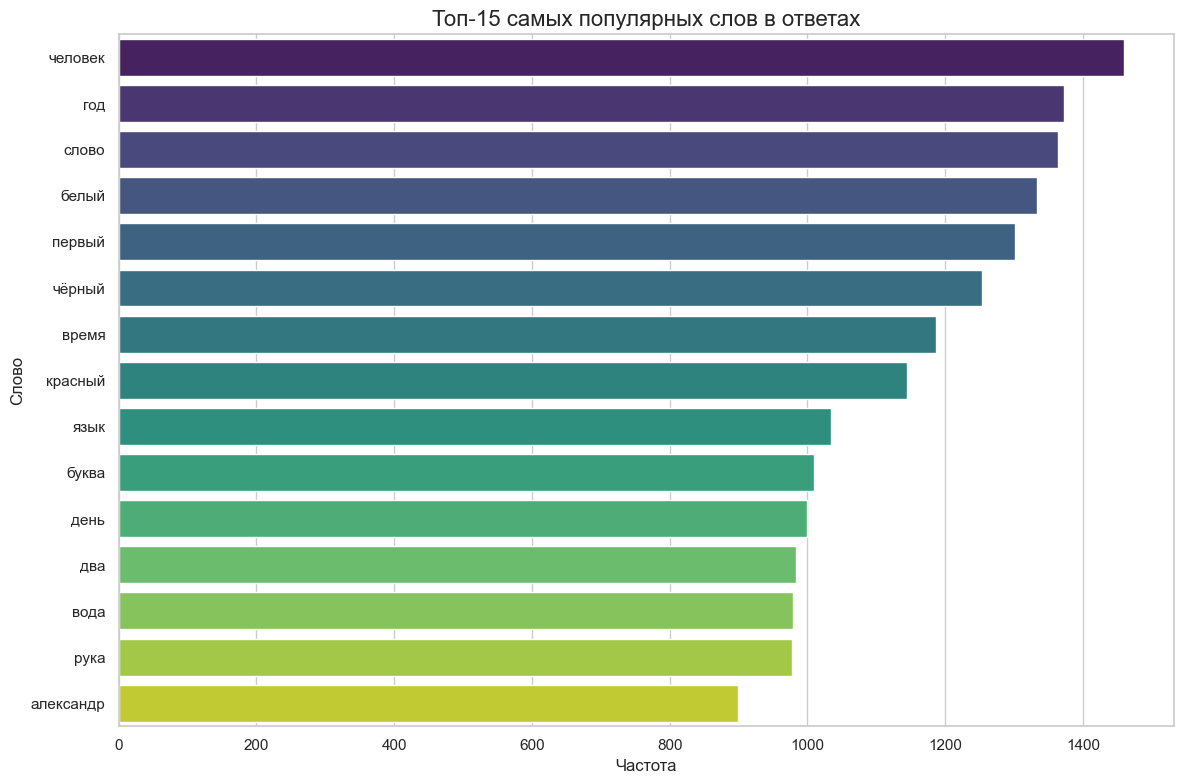

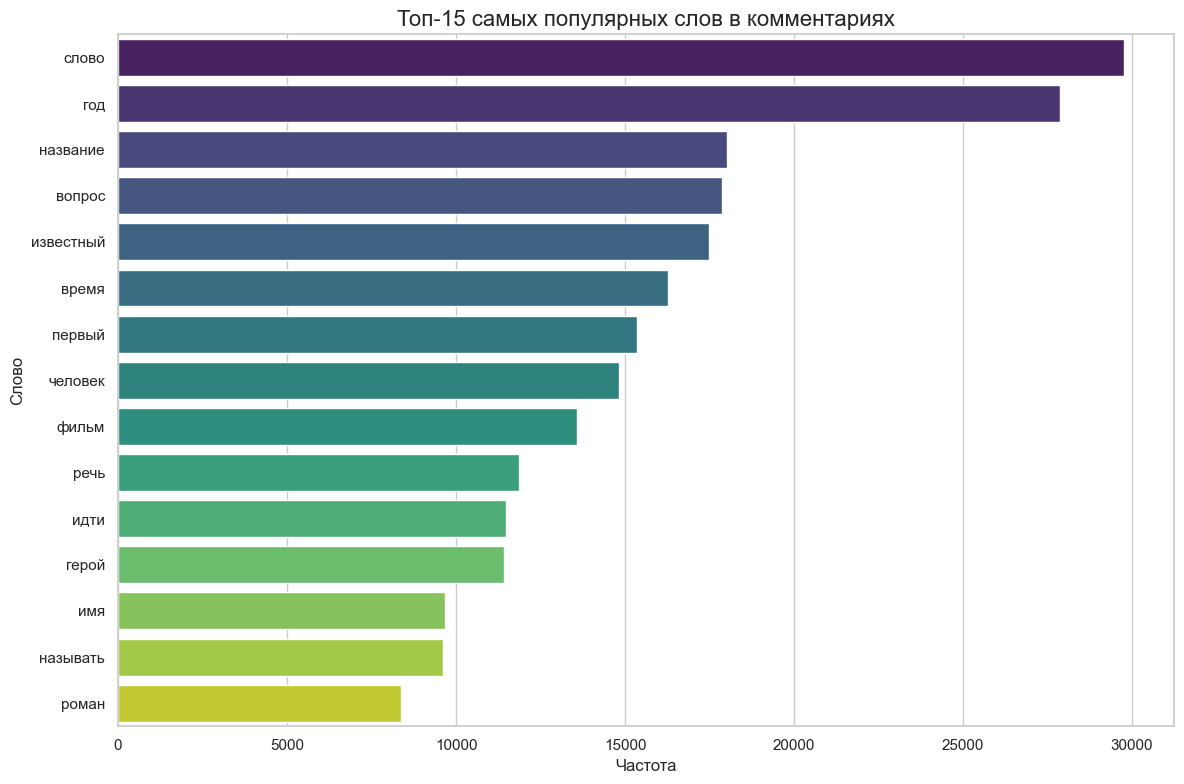

In [30]:
TOP_N_WORDS = 15


most_common_questions = get_most_common_words(df['lemmatized_q'], n=TOP_N_WORDS)
plot_most_common_words(most_common_questions, 'Топ-{} самых популярных слов в вопросах'.format(TOP_N_WORDS))

most_common_answers = get_most_common_words(df['lemmatized_a'], n=TOP_N_WORDS)
plot_most_common_words(most_common_answers, 'Топ-{} самых популярных слов в ответах'.format(TOP_N_WORDS))

most_common_comments = get_most_common_words(df['lemmatized_c'], n=TOP_N_WORDS)
plot_most_common_words(most_common_comments, 'Топ-{} самых популярных слов в комментариях'.format(TOP_N_WORDS))

### 2.4. Частотный анализ (N-граммы: Биграммы и Триграммы)

**Это ключевой шаг для поиска потенциальных именованных сущностей!** Какие устойчивые словосочетания встречаются чаще всего?

In [ ]:
def get_most_common_ngrams(corpus: pd.Series, n_gram_size: int, n: int = 20) -> list[tuple[tuple[str, ...], int]]:
    
    all_ngrams = []
    for text_list in corpus:
        if len(text_list) >= n_gram_size:
            ngrams = nltk.ngrams(text_list, n_gram_size)
            all_ngrams.extend(ngrams)

    ngram_counts = Counter(all_ngrams)

    return ngram_counts.most_common(n)

def plot_most_common_ngrams(ngram_counts: list[tuple[tuple[str, ...], int]], title: str):

    labels = [' '.join(ngram) for ngram, count in ngram_counts]
    counts = [count for ngram, count in ngram_counts]
    

    ngrams_df = pd.DataFrame({'ngram': labels, 'count': counts})
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='count', y='ngram', data=ngrams_df, palette='plasma', hue ='ngram', legend=False)
    plt.title(title, fontsize=16)
    plt.xlabel('Частота', fontsize=12)
    plt.ylabel('N-грамма', fontsize=12)
    plt.tight_layout()
    plt.show()

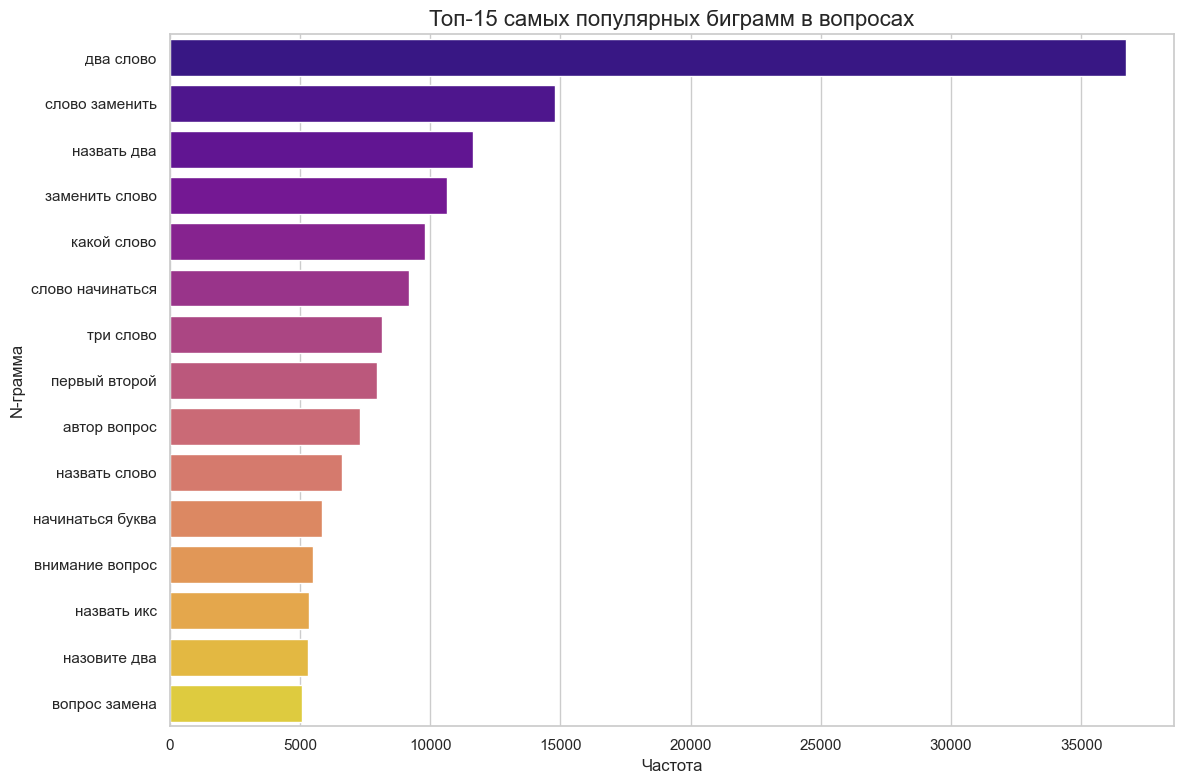

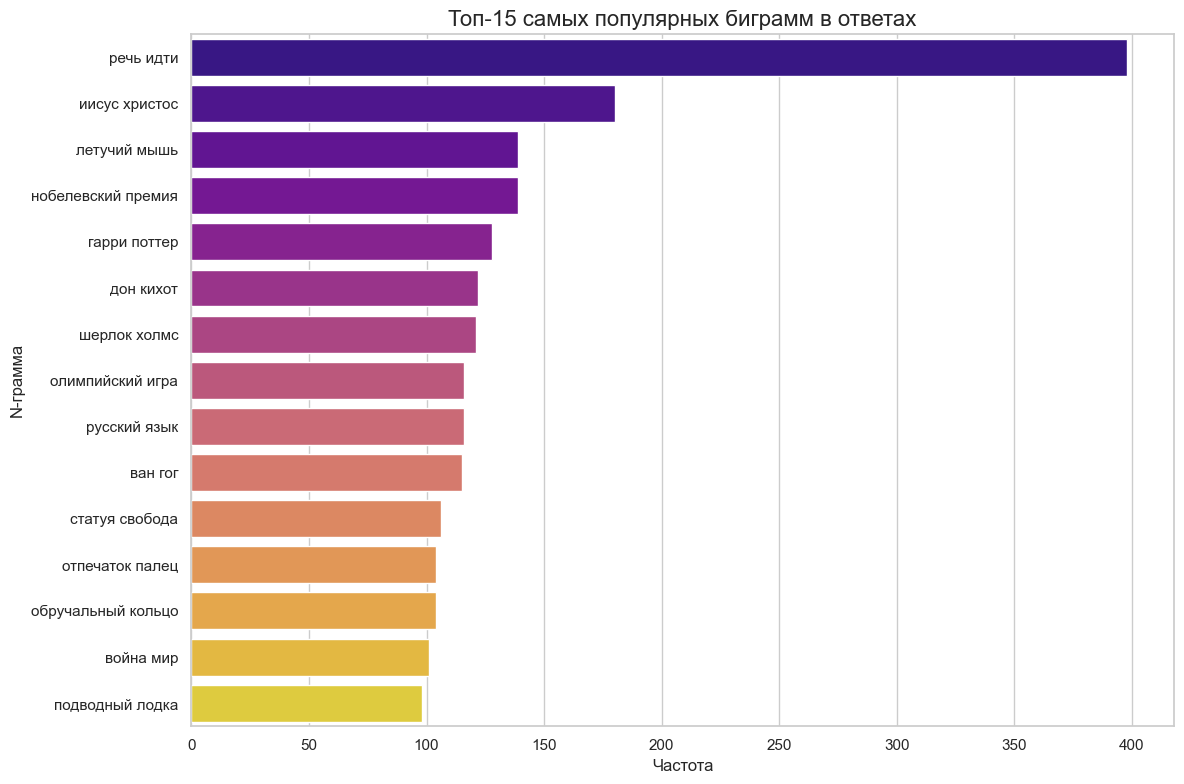

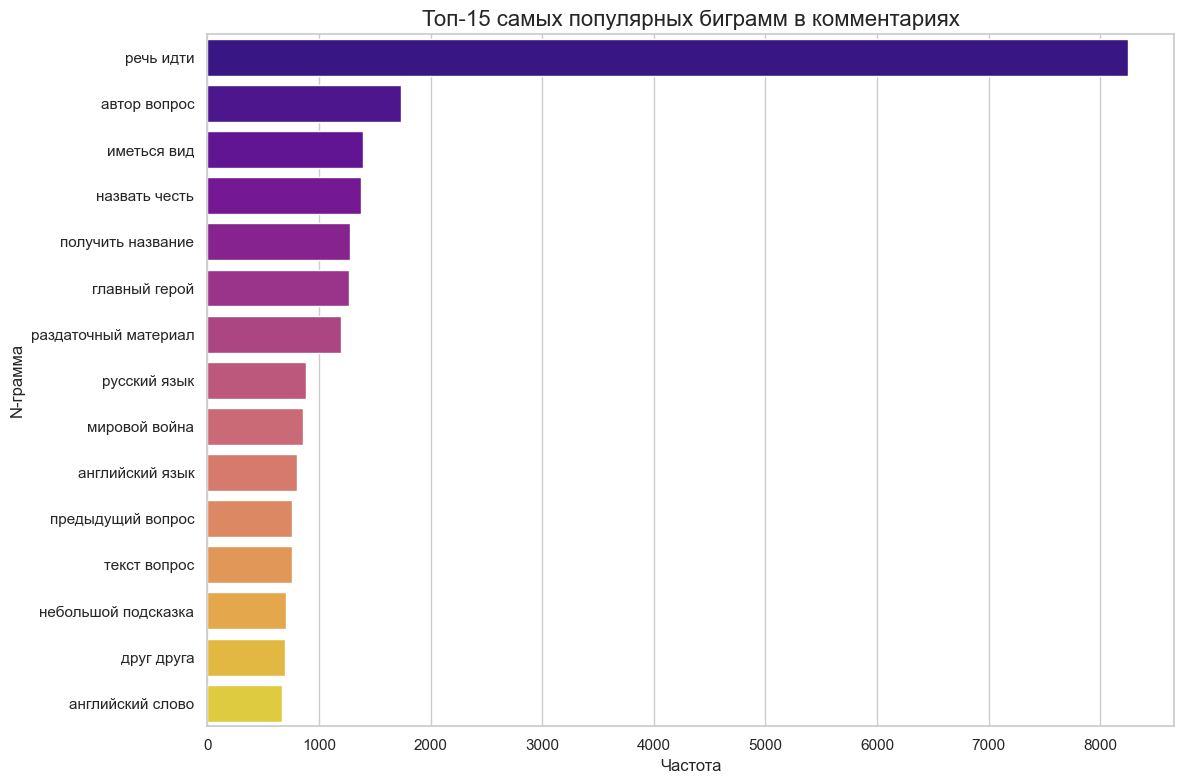

In [33]:
TOP_N_PHRASES = 15

most_common_q_bigrams = get_most_common_ngrams(df['lemmatized_q'], n_gram_size=2, n=TOP_N_PHRASES)
plot_most_common_ngrams(most_common_q_bigrams, 'Топ-{} самых популярных биграмм в вопросах'.format(TOP_N_PHRASES))

most_common_a_bigrams = get_most_common_ngrams(df['lemmatized_a'], n_gram_size=2, n=TOP_N_PHRASES)
plot_most_common_ngrams(most_common_a_bigrams, 'Топ-{} самых популярных биграмм в ответах'.format(TOP_N_PHRASES))

most_common_с_bigrams = get_most_common_ngrams(df['lemmatized_c'], n_gram_size=2, n=TOP_N_PHRASES)
plot_most_common_ngrams(most_common_с_bigrams, 'Топ-{} самых популярных биграмм в комментариях'.format(TOP_N_PHRASES))

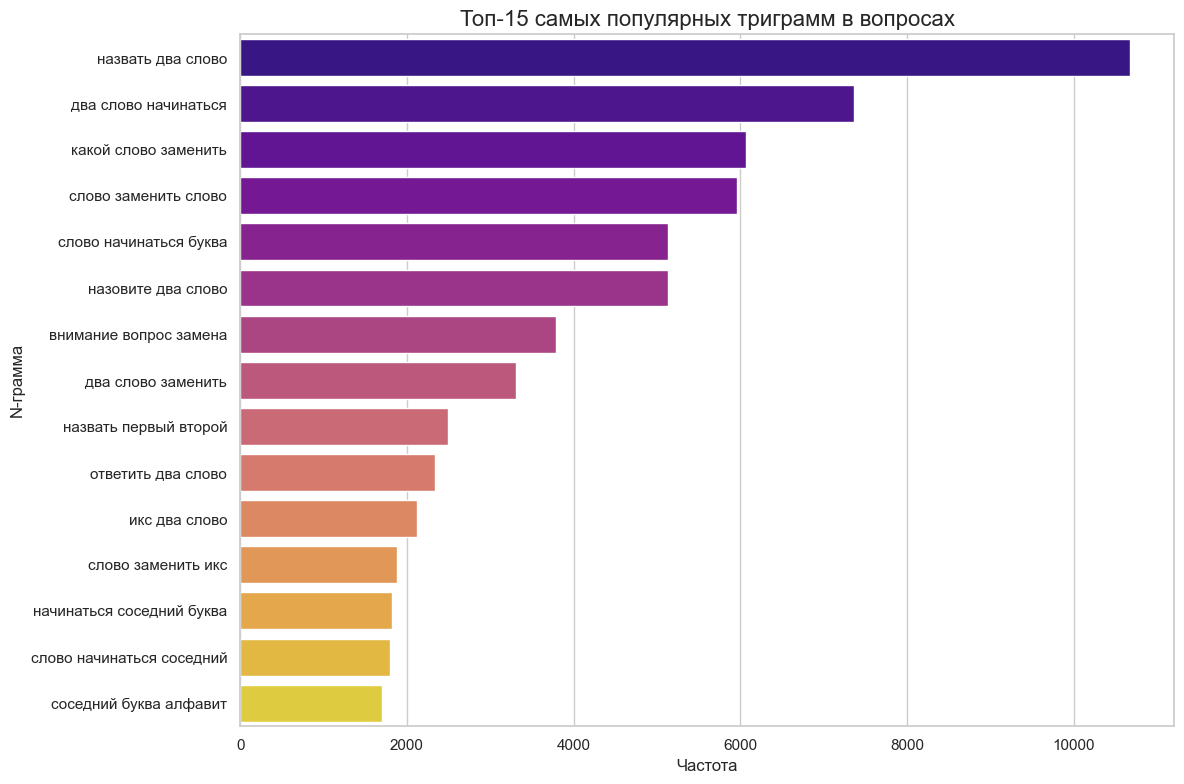

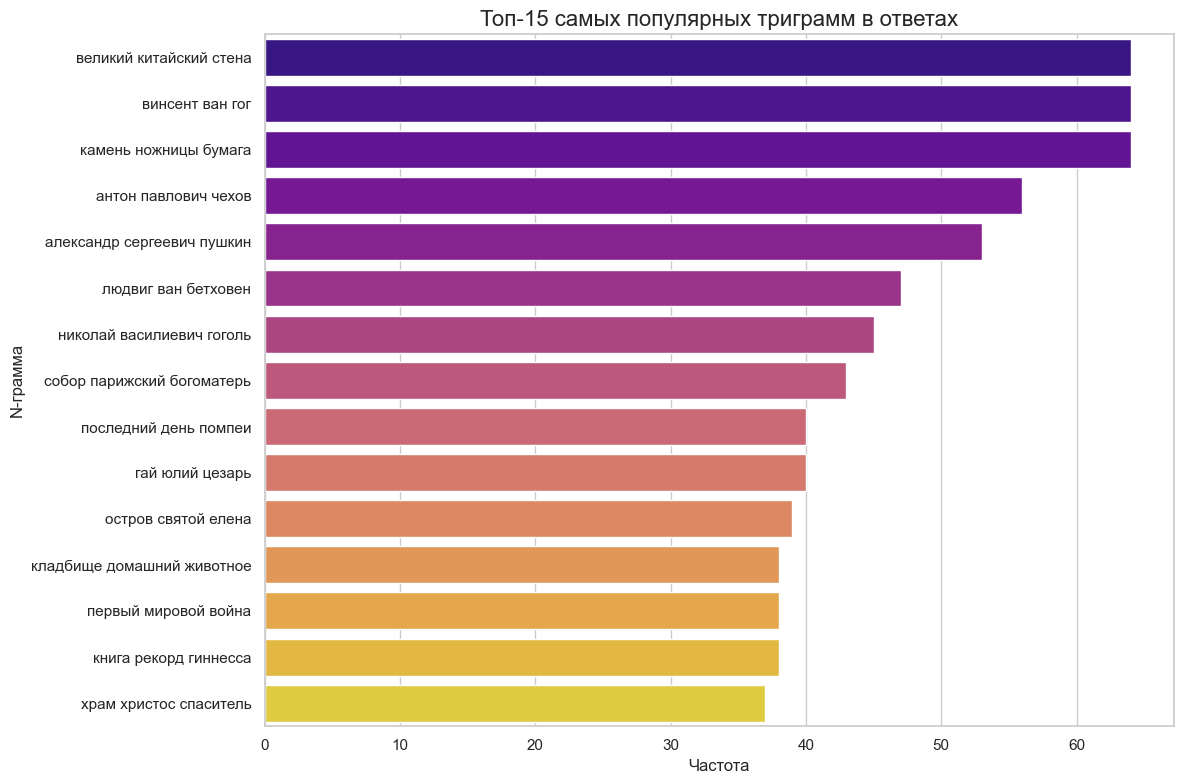

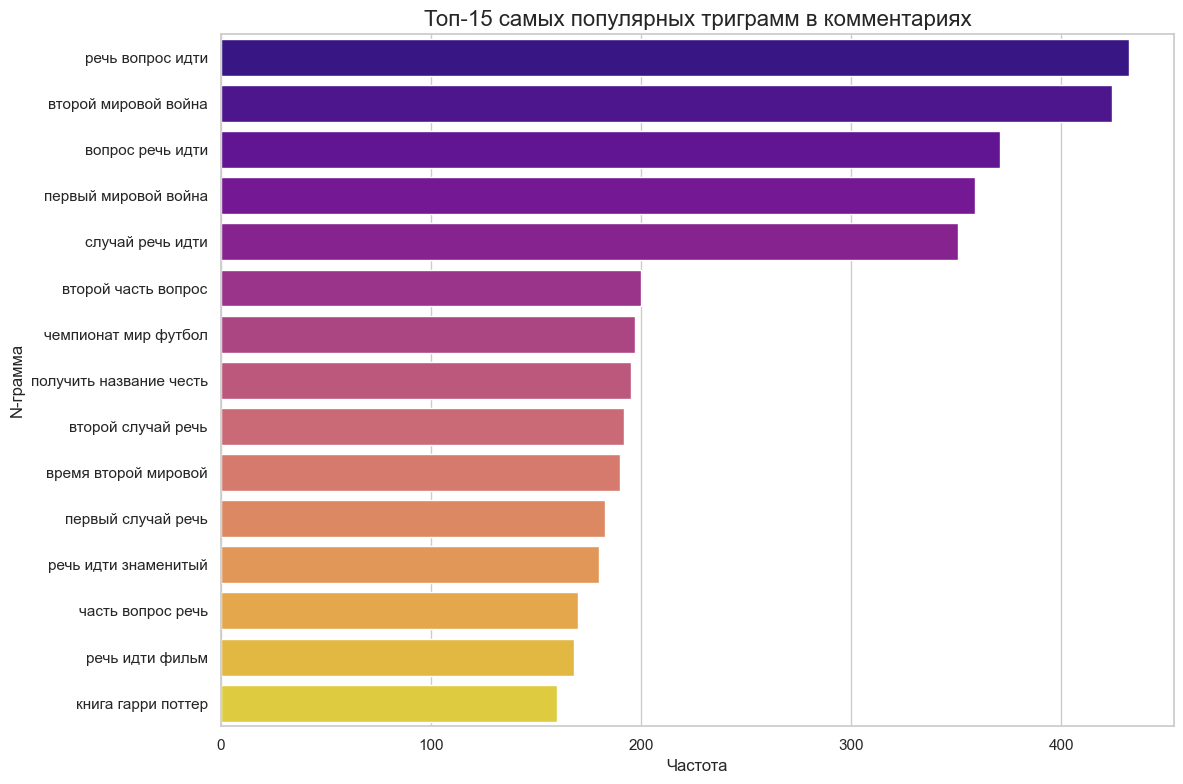

In [34]:
TOP_N_PHRASES = 15

most_common_q_bigrams = get_most_common_ngrams(df['lemmatized_q'], n_gram_size=3, n=TOP_N_PHRASES)
plot_most_common_ngrams(most_common_q_bigrams, 'Топ-{} самых популярных триграмм в вопросах'.format(TOP_N_PHRASES))

most_common_a_bigrams = get_most_common_ngrams(df['lemmatized_a'], n_gram_size=3, n=TOP_N_PHRASES)
plot_most_common_ngrams(most_common_a_bigrams, 'Топ-{} самых популярных триграмм в ответах'.format(TOP_N_PHRASES))

most_common_с_bigrams = get_most_common_ngrams(df['lemmatized_c'], n_gram_size=3, n=TOP_N_PHRASES)
plot_most_common_ngrams(most_common_с_bigrams, 'Топ-{} самых популярных триграмм в комментариях'.format(TOP_N_PHRASES))

---


## Часть 4: Ключевые инсайты
1.  **Профиль данных:** Датасет содержит 331779 вопросов, средняя длина вопроса 35 слов. Пик активности приходится на 2016 год.
2.  **Темы и сущности:** В вопросах часто встречаются названия произведений и исторических событий, а также имена авторов произведений и исторических личностей.

